In [2]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-02-12 06:56:33--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.164.176, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M  96.5MB/s    in 0.9s    

2021-02-12 06:56:34 (96.5 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
trained_weights = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, #stops the fully connected layer on the top of the model
                                weights = None)

pre_trained_model.load_weights(trained_weights)

for layer in pre_trained_model.layers:
  layer.trainable = False #freeze or lock the layers so that they don't get retrained
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
#We use drop to reduce overfitting
# Add a dropout rate of 0.2 or 20 percent
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/content/MaskWearingv22.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

#Define our example directories and files
base_dir = '/tmp/Mask Wearing.v1'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'valid')


train_Masked_dir = os.path.join(train_dir, 'Masked') # Directory with our training cat pictures
train_Unmasked_dir = os.path.join(train_dir, 'Unmasked') # Directory with our training dog pictures
validation_Masked_dir = os.path.join(validation_dir, 'Masked') # Directory with our validation cat pictures
validation_Unmasked_dir = os.path.join(validation_dir, 'unmasked')# Directory with our validation dog pictures

train_Masked_fnames = os.listdir(train_Masked_dir)
train_Unmasked_fnames = os.listdir(train_Unmasked_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 5,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 5,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))
print(classes)

Found 324 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
[[0.]]


In [10]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 1,
            epochs = 20,
            validation_steps = 5,
            verbose = 2)

Epoch 1/20
1/1 - 0s - loss: 2.5198e-06 - accuracy: 1.0000 - val_loss: 1.4118 - val_accuracy: 0.7600
Epoch 2/20
1/1 - 0s - loss: 3.7778e-06 - accuracy: 1.0000 - val_loss: 1.1890 - val_accuracy: 0.8400
Epoch 3/20
1/1 - 0s - loss: 6.0648e-06 - accuracy: 1.0000 - val_loss: 1.0875 - val_accuracy: 0.8000
Epoch 4/20
1/1 - 0s - loss: 1.4354e-05 - accuracy: 1.0000 - val_loss: 1.6688 - val_accuracy: 0.7600
Epoch 5/20
1/1 - 0s - loss: 1.9758e-05 - accuracy: 1.0000 - val_loss: 1.3671 - val_accuracy: 0.8000
Epoch 6/20
1/1 - 0s - loss: 8.6759e-05 - accuracy: 1.0000 - val_loss: 2.0068 - val_accuracy: 0.6800
Epoch 7/20
1/1 - 0s - loss: 8.3164e-07 - accuracy: 1.0000 - val_loss: 1.5225 - val_accuracy: 0.7600
Epoch 8/20
1/1 - 0s - loss: 2.3537e-07 - accuracy: 1.0000 - val_loss: 1.3713 - val_accuracy: 0.8400
Epoch 9/20
1/1 - 0s - loss: 4.6624e-07 - accuracy: 1.0000 - val_loss: 1.0367 - val_accuracy: 0.8400
Epoch 10/20
1/1 - 0s - loss: 0.2139 - accuracy: 0.8000 - val_loss: 0.4747 - val_accuracy: 0.8400
Epo

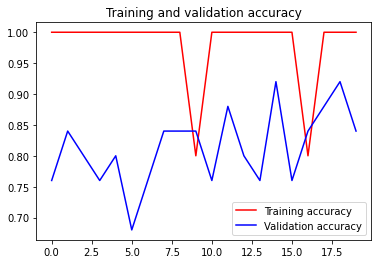

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
#uploading the test models from local system 
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving 0ad90195-cd77-489e-bf85-08c83b80d3e0_jpg.rf.794d7a9e970f6ceec349f20fb6e750b6.jpg to 0ad90195-cd77-489e-bf85-08c83b80d3e0_jpg.rf.794d7a9e970f6ceec349f20fb6e750b6.jpg
0ad90195-cd77-489e-bf85-08c83b80d3e0_jpg.rf.794d7a9e970f6ceec349f20fb6e750b6.jpg
[[0.]]
